In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facialexpressionrecognition/fer2013.csv
/kaggle/input/this-cascade/haarcascade_frontalface_default.xml


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

In [3]:
path = '../input/facialexpressionrecognition/'
os.listdir(path)

['fer2013.csv']

In [4]:
data = pd.read_csv(path + 'fer2013.csv')

In [5]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [7]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [9]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

In [10]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [11]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

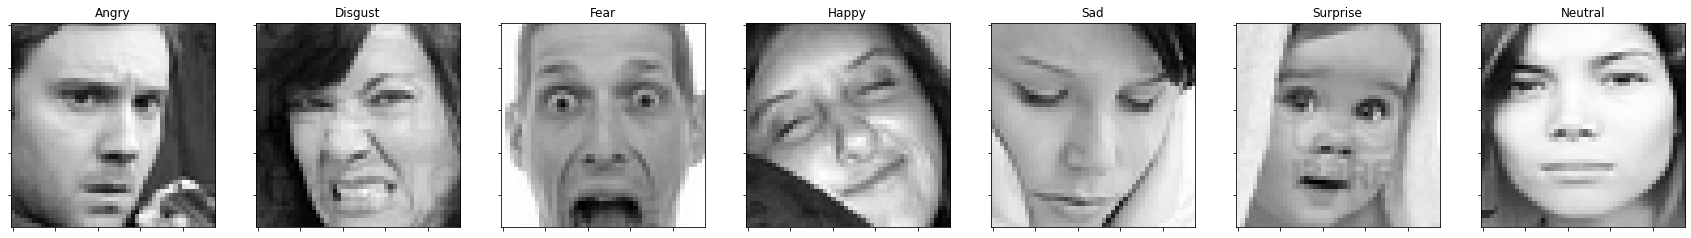

In [12]:
plot_all_emotions()

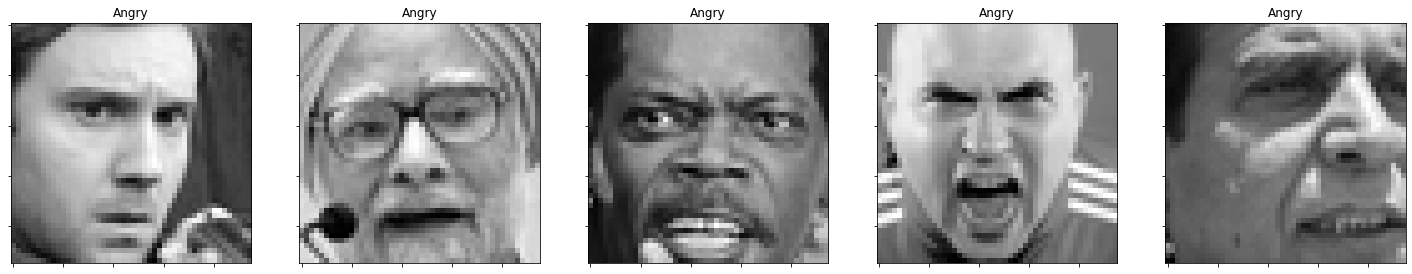

In [13]:
plot_examples(label=0)

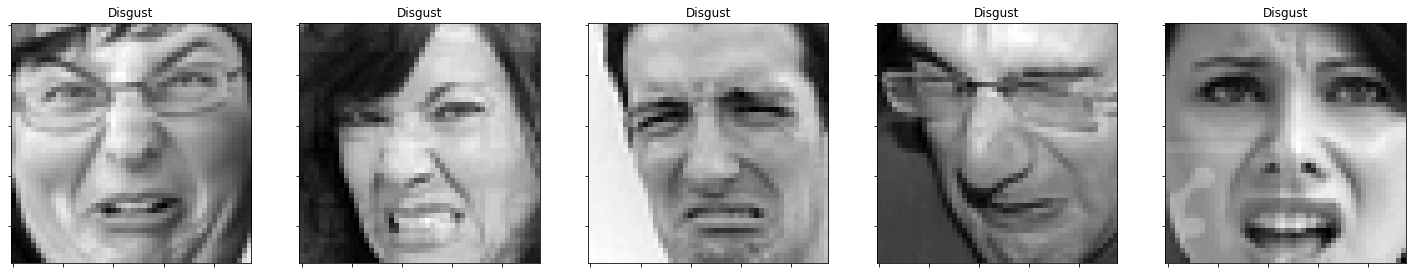

In [14]:
plot_examples(label=1)

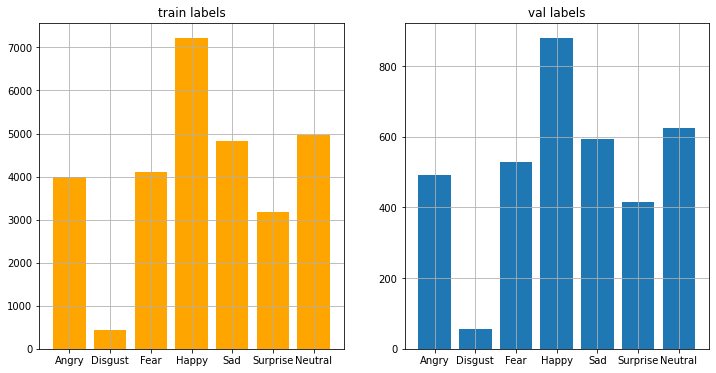

In [15]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [16]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [17]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [18]:
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping

num_features = 64
num_labels = 7
width = 48
height = 48
model = models.Sequential()
model.add(Conv2D(num_features, (3, 3), activation='relu', input_shape=(48, 48, 1),kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, (3, 3), activation='relu',padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, (3, 3), activation='relu',padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, (3, 3), activation='relu',padding='same'))
model.add(MaxPool2D((2,2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, (3, 3), activation='relu',padding='same'))
model.add(MaxPool2D((2,2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, (3, 3), activation='relu',padding='same'))
model.add(MaxPool2D((2,2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, (3, 3), activation='relu',padding='same'))
model.add(MaxPool2D((2,2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, (3, 3), activation='relu',padding='same'))
model.add(MaxPool2D((2,2), strides=(2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [19]:
from keras.losses import categorical_crossentropy

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [20]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

In [21]:
tensorboard = TensorBoard(log_dir='/kaggle/working/')

In [22]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [23]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)

NameError: name 'MODELPATH' is not defined

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

In [25]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=100,
                    batch_size=64, callbacks=[lr_reducer, early_stopper])

Epoch 1/100
449/449 [==============================] - 51s 102ms/step - loss: 0.3476 - accuracy: 0.2204 - val_loss: 1.8355 - val_accuracy: 0.2449
Epoch 2/100
449/449 [==============================] - 45s 100ms/step - loss: 0.2943 - accuracy: 0.2522 - val_loss: 2.9566 - val_accuracy: 0.2449
Epoch 3/100
449/449 [==============================] - 45s 101ms/step - loss: 0.2667 - accuracy: 0.3194 - val_loss: 1.6301 - val_accuracy: 0.3575
Epoch 4/100
449/449 [==============================] - 45s 101ms/step - loss: 0.2468 - accuracy: 0.3688 - val_loss: 1.5432 - val_accuracy: 0.4241
Epoch 5/100
449/449 [==============================] - 45s 101ms/step - loss: 0.2320 - accuracy: 0.4072 - val_loss: 1.9317 - val_accuracy: 0.3082
Epoch 6/100
449/449 [==============================] - 45s 101ms/step - loss: 0.2253 - accuracy: 0.4335 - val_loss: 1.4128 - val_accuracy: 0.4606
Epoch 7/100
449/449 [==============================] - 45s 101ms/step - loss: 0.2184 - accuracy: 0.4529 - val_loss: 1.5860 -

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 5s 43ms/step - loss: 1.2043 - accuracy: 0.6113
test caccuracy: 0.6113123297691345


In [27]:
pred_test_labels = model.predict(test_images)

In [28]:
pred_test_labels

array([[1.2559642e-01, 6.8884424e-04, 4.9773786e-02, ..., 1.0885314e-01,
        9.6713696e-03, 6.8620420e-01],
       [1.4266702e-02, 3.5146461e-04, 8.9427149e-03, ..., 2.5468616e-02,
        5.5239201e-03, 7.2598584e-02],
       [6.5320677e-01, 3.0189562e-03, 7.4438974e-02, ..., 1.9583777e-01,
        1.4334227e-04, 7.3231190e-02],
       ...,
       [1.3627483e-01, 2.8312884e-03, 1.3865663e-01, ..., 2.9525250e-01,
        2.1486808e-02, 1.4777280e-01],
       [2.8139764e-01, 2.7235157e-03, 9.0689234e-02, ..., 3.3126006e-01,
        1.9187004e-03, 2.9091278e-01],
       [1.9329479e-02, 4.0386429e-05, 2.1184277e-02, ..., 5.7262838e-02,
        6.1010622e-04, 9.0138161e-01]], dtype=float32)

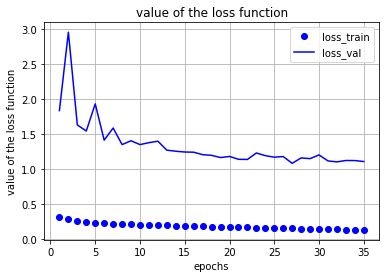

In [29]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

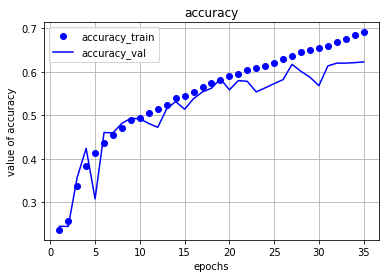

In [30]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

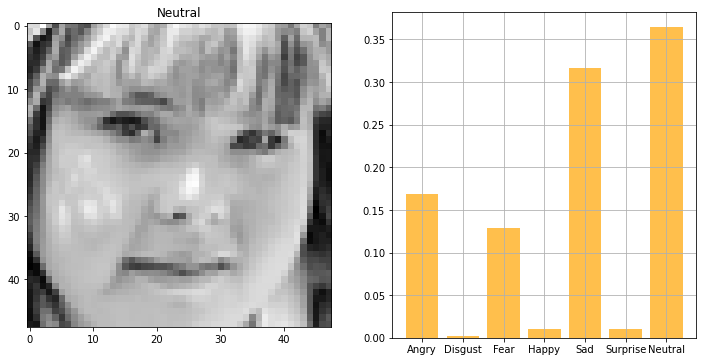

In [31]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 3)

In [32]:
model.save('model.h5')